In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pysr
from pysr import PySRRegressor

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [4]:
import sys
import os

from pathlib import Path
import glob
workdir = os.getenv("WORKDIR")
sys.path.append(workdir)

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import torch
import torch.nn as nn
#import uproot
#import awkward as ak
import copy
import shutil

#import vector

from weaver.utils.import_tools import import_module
from src.preprocessing.datasets import SimpleIterDataset
from weaver.utils.nn.tools import evaluate_classification, train_classification
from weaver.utils.logger import _logger, warn_n_times
from src.preprocessing.dataloaders import train_load, test_load
#from src.part_prediction import test_load, train_load, knowledge_distillation, optim, train_autoencoder, evaluate_autoencoder, Annealer, final_run, evaluate_surrogates

from src.handlers.hook_handler import HookHandler

from src.metrics import *

import mplhep as mh

plt.style.use(mh.style.CMS)

/home/alang/ppCodes/part_gp


RuntimeError: generic_type: cannot initialize type "RpcBackendOptions": an object with that name is already defined

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_datasets = os.getenv("PART_DATA")

In [ ]:
class Args:
    def __init__(self, **kwargs):
        # defaults
        self.data_train = []
        self.data_test = []
        self.data_val = []
        self.num_workers = 0
        self.num_epochs = 0
        self.data_config = ''
        self.extra_selection = None
        self.extra_test_selection = None
        self.file_fraction = 1
        self.data_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.batch_size = 0
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.demo = False
        self.no_remake_weights = False
        self.steps_per_epoch = None
        self.steps_per_epoch_val = None
        self.backend = None
        self.model_prefix = None
        self.lr_finder = None
        self.optimizer_option = []
        self.optimizer = 'ranger'
        self.start_lr = 1e-3
        self.final_lr = 1e-6
        self.lr_scheduler = 'flat+decay'
        self.load_epoch = None
        self.gpus = 0
        self.predict_gpus = 0
        self.regression_mode = False
        self.kl_weight = 0.1
        self.class_weight = 1.0
        
        for key, value in kwargs.items():
            setattr(self, key, value)

In [ ]:
yaml_config = workdir + '/data_config/JetClass/JetClass_kin.yaml'
teacher_path = workdir + '/models/networks/pelican_wrapper.py'
network_path = workdir + '/models/networks/part_wrapper.py'
encoder_path = workdir + '/models/networks/autoencoder.py'

jc_paths = {
    'train': path_datasets+'/JetClass/Pythia/train_100M',
    'val': path_datasets+'/JetClass/Pythia/val_5M',
    'test': path_datasets+'/JetClass/Pythia/test_20M'
}

num_classes = 2
signal = '/TTBar_*.root'
background = '/ZJetsToNuNu_*.root'

datasets = {}

for name, path in jc_paths.items():

    if isinstance(signal, str):
        signal_files = glob.glob(path+signal)

    if isinstance(background, str):
        background_files = glob.glob(path+background)

    datasets[name] = signal_files + background_files

complexity = {
    'particle_attn': 2,
    'class_attn': 1
}

In [ ]:
def initialize_CNN(network_path, config_path, training = True, model_path = None) -> dict:

    models = {}
    
    network_module = import_module(network_path, name='_network_module')
    data_config = SimpleIterDataset({}, config_path, for_training=training).config
    model, model_info = network_module.get_model(data_config)

    if model_path is not None:
        wts = torch.load(model_path, map_location = 'cpu', weights_only = True)
        model.load_state_dict(wts)
    
    model_metadata = {
        'model': model,
        'info': model_info,
        'loss': network_module.get_loss(data_config)
    }

    return model_metadata

def initialize_PELICAN(network_path, config_path, training = True, model_path = None) -> dict:

    models = {}
    
    network_module = import_module(network_path, name='_network_module')
    data_config = SimpleIterDataset({}, config_path, for_training=training).config
    model, model_info = network_module.get_model(data_config,
                                                 dataset='',
                                                 method='spurions',
                                                 stabilizer='so2',
                                                 average_nobj=16,
                                                 scale=0.1,
                                                 num_channels_scalar=10,
                                                 num_channels_m=[[60],]*5,
                                                 num_channels_2to2=[35,]*5,
                                                 num_channels_out=[60],
                                                 num_channels_m_out=[60, 35]
                                                )

    if model_path is not None:
        wts = torch.load(model_path, map_location = 'cpu', weights_only = True)
        model.load_state_dict(wts)
    
    model_metadata = {
        'model': model,
        'info': model_info,
        'loss': network_module.get_loss(data_config)
    }

    return model_metadata

def initialize_VAE(network_path, config_path, training = True, model_path = None) -> dict:

    models = {}
    
    network_module = import_module(network_path, name='_network_module')
    data_config = SimpleIterDataset({}, config_path, for_training=training).config
    model, model_info = network_module.get_model(data_config, phi_sizes=(256, 256, 256), fc_sizes = (256, 256, 256))

    if model_path is not None:
        wts = torch.load(model_path, map_location = 'cpu', weights_only = True)
        model.load_state_dict(wts)
    
    model_metadata = {
        'model': model,
        'info': model_info,
        'loss': network_module.get_loss(data_config)
    }

    return model_metadata

def initialize_part(network_path, config_path, training = True, model_path = None) -> dict:

    models = {}
    
    network_module = import_module(network_path, name='_network_module')
    data_config = SimpleIterDataset({}, config_path, for_training=training).config
    model, model_info = network_module.get_model(data_config, num_layers = complexity['particle_attn'], num_cls_layers = complexity['class_attn'])

    if model_path is not None:
        wts = torch.load(model_path, map_location = 'cpu', weights_only = True)
        model.load_state_dict(wts)
    
    model_metadata = {
        'model': model,
        'info': model_info,
        'loss': network_module.get_loss(data_config)
    }

    return model_metadata

In [6]:
model = PySRRegressor.from_file(run_directory =workdir + '/outputs/sr_runs/old/20260210_080518_xZRdYE')

Attempting to load model from /home/alang/ppCodes/part_gp/outputs/sr_runs/old/20260210_080518_xZRdYE/checkpoint.pkl...


In [7]:
print(model)

PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                        -0.31211296   
	1         0.143892                                    x2 * -260.16965   
	2         0.000121                              tanh(x2) * -260.27905   
	3   >>>>  0.133653                             (x2 + x1) * -259.92557   
	4         0.000172                         -259.92557 * tanh(x1 + x2)   
	5         0.048161              ((x2 * 0.44932947) + x1) * -476.75858   
	6         0.083699            sin((x2 + x1) * -56.983482) * 6.7255774   
	7         0.007001       8.278529 * tanh(sin((x2 + x1) * -52.140278))   
	8         0.036040  tanh((x1 + x2) / (x2 + -0.022940155)) * 10.986184   
	9         0.002329  sin(tanh((x2 + x1) / (x2 + -0.02518627))) * 12...   
	10        0.067713  (x1 + x2) * (tanh(-0.018626638 / (x2 + -0.0058...   
	11        0.000013  tanh(-0.018626638 / (sin(x2) + -0.0058588497))...   
	12    

In [24]:
from pysr import jl

options = model.julia_options_

# Define operators for creating trees:
jl.options = options  # Store `options` in Julia namespace
jl.seval("@extend_operators options")  # Declare available operators

x1 = SR.Node(jl.Float32, feature=1) # If x is the first column (index 0 in Python)
# Store x1 in Julia namespace:
jl.x1 = x1
# Create equation from string:
eqn = jl.seval("x1 + 1")

AttributeError: Julia: Global Main.options does not exist and cannot be assigned.
Note: Julia 1.9 and 1.10 inadvertently omitted this error check (#56933).
Hint: Declare it using `global options` inside `Main` before attempting assignment.

In [41]:
modules = model.pytorch([25, 15])

In [42]:
vae_metadata = initialize_VAE(encoder_path, yaml_config, training=False, model_path = workdir + '/models/torch_saved/DSEncoder_epoch-1_state.pt')
autoencoder = copy.deepcopy(vae_metadata['model']).to(device)

In [43]:
class Surrogate(torch.nn.Module):
    def __init__(self, modules, encoder):
        super().__init__()

        self.autoencoder = encoder
        self.bkg, self.signal = modules

    def forward(self, points, features, lorentz_vectors, mask):

        x, mean, log_var, z = self.autoencoder(points, features, lorentz_vectors, mask)
        bkg_logit = self.bkg(torch.cat([mean, log_var], axis=1)).unsqueeze(1)
        signal_logit = self.signal(torch.cat([mean, log_var], axis=1)).unsqueeze(1)

        return (torch.cat([bkg_logit, signal_logit], axis=1), x, mean, log_var, z)

class SurrogateWrapper(torch.nn.Module):
    def __init__(self, modules, encoder):
        super().__init__()

        self.mod = Surrogate(modules, encoder)

    def forward(self, points, features, lorentz_vectors, mask):

        return self.mod(points, features, lorentz_vectors, mask)

In [44]:
predictor = SurrogateWrapper(modules, autoencoder).to(device)

In [10]:
args = Args(
    data_train = datasets['train'],
    data_val = datasets['val'],
    data_test = datasets['test'],
    data_config = yaml_config,
    num_epochs = 3,
    batch_size = 128,
    model_prefix = 'models/torch_saved/DSVAE',
    file_fraction = 1,
    data_fraction = 0.1
)

train_loader, val_loader, data_config, train_input_names, train_label_names = train_load(args)

pred_args = Args(
    data_test = datasets['test'],
    data_config = yaml_config,
    batch_size = 128,
    file_fraction = 1,
    data_fraction = 0.1
)

test_loaders, test_config = test_load(pred_args)

In [45]:
pred_args = Args(
    data_test = datasets['test'],
    data_config = yaml_config,
    batch_size = 64,
    file_fraction = 1,
    data_fraction = 0.1
)

test_loaders, data_config = test_load(pred_args)

hook_manager = {
    'forward_hooks': {},
    'pre_forward_hooks': {}
}

handles, outputs = HookHandler(predictor, hook_manager).registration(safety_remove = True)

outputs['forward_hooks']['logits'] = []

output_hook = predictor.mod.register_forward_hook(HookHandler.save_outputs('logits', outputs['forward_hooks']))

for name, get_test_loader in test_loaders.items():
    
    test_loader = get_test_loader()
    
    test_metric, scores, labels, observers = evaluate_surrogates(predictor, test_loader, device, epoch=None, for_training=False)
    
    del test_loader


Removing all hooks within the model


0it [00:00, ?it/s]

=== Restarting DataIter test_, seed=None ===


6250it [06:17, 16.54it/s, Loss=0.00000, AvgLoss=0.00000, Acc=0.82812, AvgAcc=0.81787] 


In [36]:
len(outputs['forward_hooks']['logits'][:, 0])

TypeError: list indices must be integers or slices, not tuple

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 400000) + inhomogeneous part.

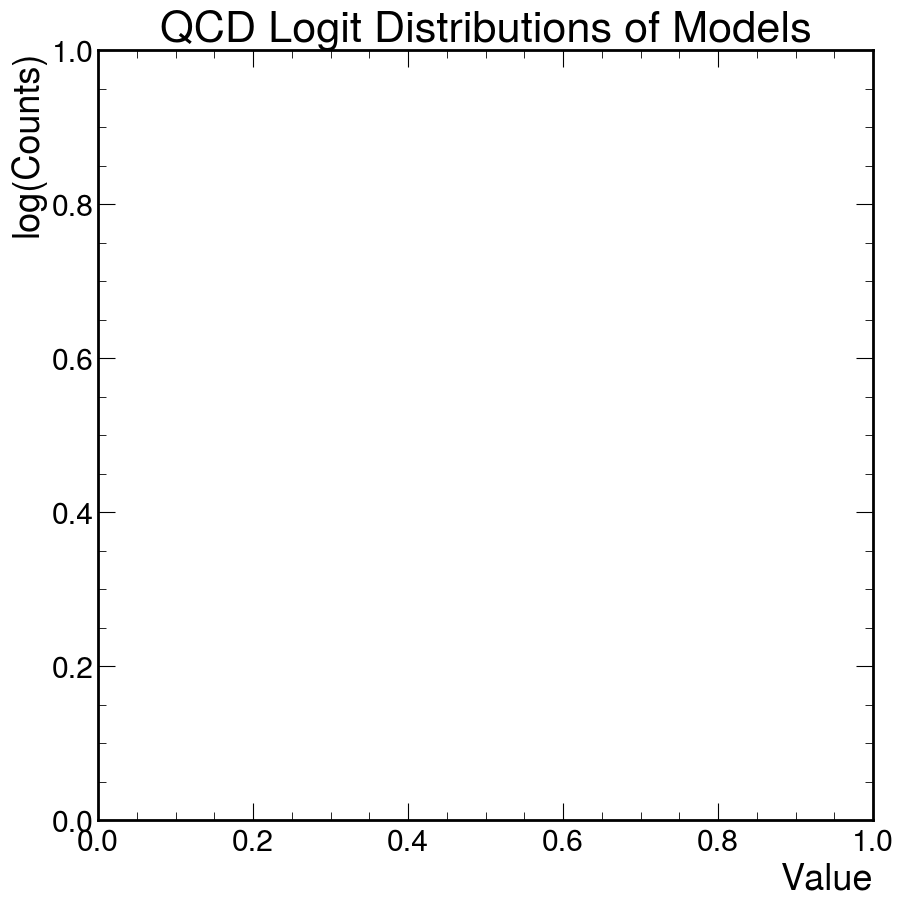

In [38]:
logits = []

for v in range(3):
    if outputs['forward_hooks']['logits'][0][v] is None:
        continue
    
    logits.append(
        torch.cat(
            [outputs['forward_hooks']['logits'][i][v].cpu() for i in range(len(outputs['forward_hooks']['logits']))],
            dim=0
        ).numpy()
    )

fig, axes = plt.subplots()

axes.set_title('QCD Logit Distributions of Models')
axes.set_xlabel('Value')
axes.set_ylabel('log(Counts)')
bins = 100
    
axes.hist(np.max(logits, axis=1), bins=bins, label=r'Symbolic Model', alpha=1)
axes.set_yscale('log')
axes.legend()

plt.show()